In [1]:
import sys, os
import h5py
import numpy as np
from joblib import delayed, Parallel
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

from hyppo.independence import KMERF

sys.path.append(os.path.realpath('..'))

In [2]:
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:], n_colors=9)

In [3]:
# import mat file
arrays = {}
f = h5py.File("../kmerf/real_data/proteomics.mat")
for k, v in f.items():
    arrays[k] = np.array(v)

In [4]:
def compute_pvalue(D, A, per, i):
    C = A[per.ravel(), i]
    pvalue = KMERF().test(C, D, reps=10000)[1]
    return pvalue


def generate_perd(labelindall, vs_type):
    if vs_type == "pancvsnormal":
        per = np.logical_or(labelindall == 1, labelindall == 2)
    elif vs_type == "pancvsall":
        per = np.logical_and(labelindall != 2, labelindall < 5)
        labelindall[per] = 1
        per = labelindall < 5
    else:
        raise ValueError("vs_type must be pancvsnormal or pancvsall")
        
    D = labelindall[per]
        
    return per, D


def generate_pvalues(arrays, vs_type="pancvsnormal"):
    labelindall = arrays['LabelIndAll']
    A = arrays['A']
    
    per, D = generate_perd(labelindall, vs_type)
    
    pvalues = Parallel(n_jobs=-1, verbose=100)(
        [delayed(compute_pvalue)(D, A, per, i) for i in range(A.shape[1])]
    )
    return pvalues

In [ ]:
panc_vs_normal = generate_pvalues(arrays, vs_type="pancvsnormal")
panc_vs_all = generate_pvalues(arrays, vs_type="pancvsall")
np.savetxt('../kmerf/real_data/panc_vs_normal.csv', panc_vs_normal, delimiter=',')
np.savetxt('../kmerf/real_data/panc_vs_all.csv', panc_vs_all, delimiter=',')

In [5]:
def plot_real_data():
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    panc_vs_normal = np.genfromtxt('../kmerf/real_data/panc_vs_normal.csv', delimiter=',')
    panc_vs_all = np.genfromtxt('../kmerf/real_data/panc_vs_all.csv', delimiter=',')
    
    ax1.scatter(panc_vs_normal, panc_vs_all, c="#4daf4a", s=75)
    ax1.scatter(panc_vs_normal[180], panc_vs_all[180], c="#e41a1c", s=100)
    ax1.text(panc_vs_normal[180]+0.00005, panc_vs_all[180]+0.00005, c="#e41a1c", s="neurogranin")
    ax1.axhline(y=0.001, linestyle='--')
    ax1.axvline(x=0.001, linestyle='--')
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_xlabel("p-values for Panc vs Norm")
    ax1.set_ylabel("p-values for Panc vs All")
    ax1.set_xticks([1e-4, 1e-2, 1e0])
    ax1.set_yticks([1e-4, 1e-2, 1e0])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_title('Cancer Biomarker Discovery', pad=20)
    
    # See https://elifesciences.org/articles/41690#fig4
    labels = ["False Positives", "True Positives"]
    kmerf = [2, 5]
    hsic = [4, 5]
    hhg = [2, 1]
    width = 0.25  # the width of the bars
    r2 = np.arange(len(kmerf))
    r1 = [x - width for x in r2]
    r3 = [x + width for x in r2]
    x = np.arange(len(labels))  # the label locations
    ax2.bar(r1, kmerf, width, color="#e41a1c", label="KMERF")
    ax2.bar(r2, hsic, width, color="#4daf4a", label="Hsic")
    ax2.bar(r3, hhg, width, color="#984ea3", label="HHG")
    ax2.set_ylabel("# True / False Positives")
    ax2.set_ylim([0, 8])
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)
    plt.legend()
    ax2.set_title('Biomarker kNN Classification', pad=20)
    leg = plt.legend(bbox_to_anchor=(0.8, 0.9), bbox_transform=plt.gcf().transFigure,
                     ncol=1, loc='upper center', labelspacing=.1)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    plt.subplots_adjust(wspace=0.50)
    plt.savefig('../kmerf/figs/real_data.pdf', transparent=True, bbox_inches='tight')

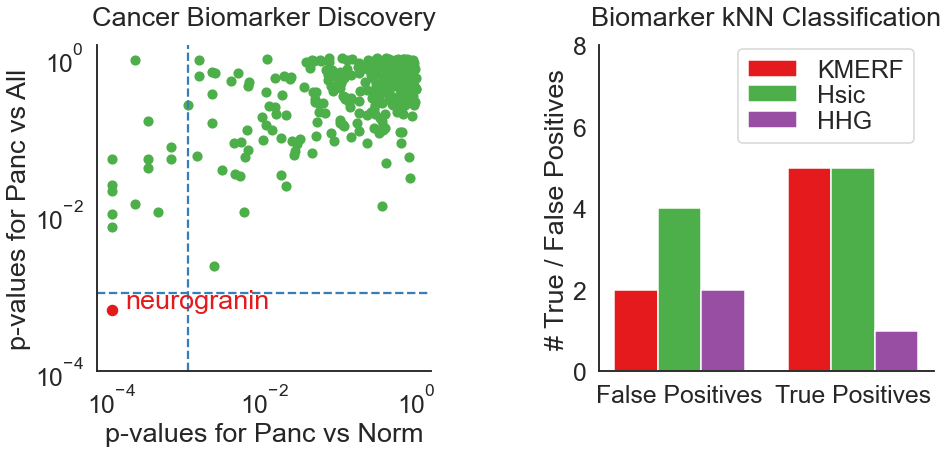

In [6]:
plot_real_data()